In [1]:
# Import the libraries we will need
import pandas as pd
import numpy as np

import findspark
findspark.init()

from pyspark.sql import *
import pyspark.sql.functions as F
from pyspark.sql.types import *

# create the Spark Session
spark = SparkSession.builder.appName("Q2").getOrCreate()

In [2]:
data = spark.read.csv("hw2-bundle/hw2-bundle/kmeans/data/data.txt").toDF("observation")
data = data.withColumn("observation", F.split(F.col("observation"), " ").cast("array<float>"))
data = data.withColumn("obs_index", F.monotonically_increasing_id())
window = Window.orderBy(F.col("obs_index"))
data = data.withColumn("obs_index", F.row_number().over(window) - 1)

init_C_random = spark.read.csv("hw2-bundle/hw2-bundle/kmeans/data/c1.txt").toDF("centroid")
init_C_random = init_C_random.withColumn("centroid", F.split(F.col("centroid"), " ").cast("array<float>"))
init_C_random = init_C_random.withColumn("c_index", F.monotonically_increasing_id())
window = Window.orderBy(F.col("c_index"))
init_C_random = init_C_random.withColumn("c_index", F.row_number().over(window) - 1)

init_C_far = spark.read.csv("hw2-bundle/hw2-bundle/kmeans/data/c2.txt").toDF("centroid")
init_C_far = init_C_far.withColumn("centroid", F.split(F.col("centroid"), " ").cast("array<float>"))
init_C_far = init_C_far.withColumn("c_index", F.monotonically_increasing_id())
window = Window.orderBy(F.col("c_index"))
init_C_far = init_C_far.withColumn("c_index", F.row_number().over(window) - 1)

In [3]:
data.show(5)

+--------------------+---------+
|         observation|obs_index|
+--------------------+---------+
|[0.0, 0.64, 0.64,...|        0|
|[0.21, 0.28, 0.5,...|        1|
|[0.06, 0.0, 0.71,...|        2|
|[0.0, 0.0, 0.0, 0...|        3|
|[0.0, 0.0, 0.0, 0...|        4|
+--------------------+---------+
only showing top 5 rows



In [4]:
init_C_random.show(10)

+--------------------+-------+
|            centroid|c_index|
+--------------------+-------+
|[0.0, 0.64, 0.64,...|      0|
|[0.21, 0.28, 0.5,...|      1|
|[0.06, 0.0, 0.71,...|      2|
|[0.0, 0.0, 0.0, 0...|      3|
|[0.0, 0.0, 0.0, 0...|      4|
|[0.0, 0.0, 0.0, 0...|      5|
|[0.0, 0.0, 0.0, 0...|      6|
|[0.0, 0.0, 0.0, 0...|      7|
|[0.15, 0.0, 0.46,...|      8|
|[0.06, 0.12, 0.77...|      9|
+--------------------+-------+



In [5]:
def l1_distance(x, y):
    return float(np.linalg.norm(np.array(x) - np.array(y), ord=1))
l1_distance_udf = F.udf(l1_distance, FloatType())

def l2_distance(x, y):
    return float(np.linalg.norm(np.array(x) - np.array(y), ord=2) ** 2)
l2_distance_udf = F.udf(l2_distance, FloatType())

In [6]:
def k_means(observation, initial_centroids, max_iter):
    def l2_distance(x, y):
        return float(np.linalg.norm(np.array(x) - np.array(y), ord=2) ** 2)
    l2_distance_udf = F.udf(l2_distance, FloatType())

    cost = np.zeros(max_iter + 1)

    # iteration 0 (initialization)
    new_partitions = observation.crossJoin(initial_centroids)
    new_partitions = new_partitions.withColumn("obs_to_c_dist", l2_distance_udf(F.col("observation"), F.col("centroid")))

    window = Window.partitionBy("obs_index")
    new_partitions = new_partitions.withColumn("min_dist", F.min("obs_to_c_dist").over(window))
    new_partitions = new_partitions.filter(((F.col("min_dist") - F.col("obs_to_c_dist")) < 1e-6) &
                                        ((F.col("obs_to_c_dist") - F.col("min_dist")) < 1e-6)).sort("obs_index").drop("min_dist")

    new_centroids = new_partitions.rdd.map(lambda row: (row.c_index, row.observation))
    new_centroids = new_centroids.reduceByKey(lambda x, y: (np.array(x) + np.array(y)).tolist())
    new_centroids = new_centroids.toDF().withColumnsRenamed({"_1": "c_index", "_2": "centroid"})
    new_centroids = new_centroids.join(new_partitions.groupBy("c_index").count(), on="c_index", how="inner")
    new_centroids = new_centroids.withColumn("centroid", (F.udf(lambda x, y: (np.array(x) / y).tolist(), "array<float>"))(F.col("centroid"), F.col("count")))
    new_centroids = new_centroids.drop("count").sort("c_index")

    cost[0] = np.sum(new_partitions.select("obs_to_c_dist").rdd.flatMap(lambda x: x).collect())
    print(f"At iteration 0, the cost is {cost[0]}.")

    # rest iterations
    for t in np.arange(1, max_iter + 1):
        new_partitions = observation.crossJoin(new_centroids)
        new_partitions = new_partitions.withColumn("obs_to_c_dist", l2_distance_udf(F.col("observation"), F.col("centroid")))

        window = Window.partitionBy("obs_index")
        new_partitions = new_partitions.withColumn("min_dist", F.min("obs_to_c_dist").over(window))
        new_partitions = new_partitions.filter(((F.col("min_dist") - F.col("obs_to_c_dist")) < 1e-6) &
                                            ((F.col("obs_to_c_dist") - F.col("min_dist")) < 1e-6)).sort("obs_index").drop("min_dist")

        new_centroids = new_partitions.rdd.map(lambda row: (row.c_index, row.observation))
        new_centroids = new_centroids.reduceByKey(lambda x, y: (np.array(x) + np.array(y)).tolist())
        new_centroids = new_centroids.toDF().withColumnsRenamed({"_1": "c_index", "_2": "centroid"})
        new_centroids = new_centroids.join(new_partitions.groupBy("c_index").count(), on="c_index", how="inner")
        new_centroids = new_centroids.withColumn("centroid", (F.udf(lambda x, y: (np.array(x) / y).tolist(), "array<float>"))(F.col("centroid"), F.col("count")))
        new_centroids = new_centroids.drop("count").sort("c_index")

        cost[t] = np.sum(new_partitions.select("obs_to_c_dist").rdd.flatMap(lambda x: x).collect())

        print(f"At iteration {t}, the cost is {cost[t]}.")

        new_centroids = new_centroids.collect()
        new_centroids = spark.createDataFrame(data=new_centroids)
    
    return cost, new_centroids.collect()

In [8]:
random_init_l2_distance_result = k_means(data, init_C_random, 20)

At iteration 0, the cost is 623747853.501003.
At iteration 1, the cost is 509851311.6232786.
At iteration 2, the cost is 485474455.838027.
At iteration 3, the cost is 463988317.16985035.
At iteration 4, the cost is 460962508.4620385.
At iteration 5, the cost is 460535298.3988676.
At iteration 6, the cost is 460318802.282403.
At iteration 7, the cost is 460080310.9470396.
At iteration 8, the cost is 459741192.7645869.
At iteration 9, the cost is 459268145.28618383.
At iteration 10, the cost is 458712994.45715284.
At iteration 11, the cost is 458078769.6091542.
At iteration 12, the cost is 457650806.15269756.
At iteration 13, the cost is 457326253.1740484.
At iteration 14, the cost is 457050434.7209182.
At iteration 15, the cost is 456904554.2070093.
At iteration 16, the cost is 456689185.8974581.
At iteration 17, the cost is 456376825.21881723.
At iteration 18, the cost is 456152453.9466014.
At iteration 19, the cost is 455954422.3111315.
At iteration 20, the cost is 455694378.469656.


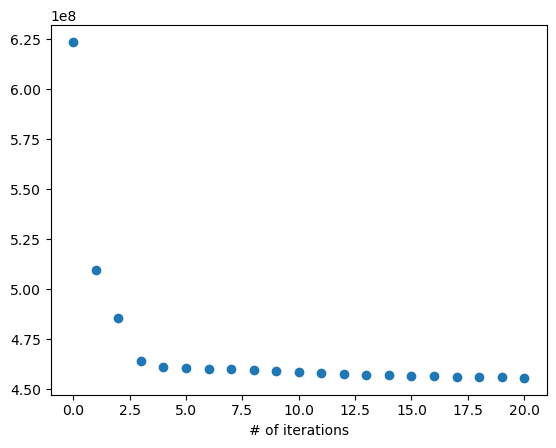

In [9]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.scatter(np.arange(0, 21), random_init_l2_distance_result[0])
ax.set_xlabel("# of iterations")
plt.show()

In [12]:
random_init_l2_distance_result[0][20]

455694378.469656

In [13]:
1 - random_init_l2_distance_result[0][10] / random_init_l2_distance_result[0][0]

0.2645858548731419

In [14]:
new_partitions = data.crossJoin(init_C_random)
new_partitions = new_partitions.withColumn("obs_to_c_dist", l2_distance_udf(F.col("observation"), F.col("centroid")))

window = Window.partitionBy("obs_index")
new_partitions = new_partitions.withColumn("min_dist", F.min("obs_to_c_dist").over(window))
new_partitions = new_partitions.filter(((F.col("min_dist") - F.col("obs_to_c_dist")) < 1e-6) &
                                    ((F.col("obs_to_c_dist") - F.col("min_dist")) < 1e-6)).sort("obs_index").drop("min_dist")

# new_centroids = new_partitions.rdd.map(lambda row: (row.c_index, row.observation))
# new_centroids = new_centroids.reduceByKey(lambda x, y: (np.array(x) + np.array(y)).tolist())
# new_centroids = new_centroids.toDF().withColumnsRenamed({"_1": "c_index", "_2": "centroid"})
# new_centroids = new_centroids.join(new_partitions.groupBy("c_index").count(), on="c_index", how="inner")
# new_centroids = new_centroids.withColumn("centroid", (F.udf(lambda x, y: (np.array(x) / y).tolist(), "array<float>"))(F.col("centroid"), F.col("count")))
# new_centroids = new_centroids.drop("count").sort("c_index")


In [15]:
new_partitions.show(5)

+--------------------+---------+--------------------+-------+-------------+
|         observation|obs_index|            centroid|c_index|obs_to_c_dist|
+--------------------+---------+--------------------+-------+-------------+
|[0.0, 0.64, 0.64,...|        0|[0.0, 0.64, 0.64,...|      0|          0.0|
|[0.21, 0.28, 0.5,...|        1|[0.21, 0.28, 0.5,...|      1|          0.0|
|[0.06, 0.0, 0.71,...|        2|[0.06, 0.0, 0.71,...|      2|          0.0|
|[0.0, 0.0, 0.0, 0...|        3|[0.0, 0.0, 0.0, 0...|      3|          0.0|
|[0.0, 0.0, 0.0, 0...|        4|[0.0, 0.0, 0.0, 0...|      4|          0.0|
+--------------------+---------+--------------------+-------+-------------+
only showing top 5 rows



In [44]:
new_centroids = new_partitions.rdd.map(lambda row: (row.c_index, row.observation))

In [18]:
new_centroids.take(5)

[(0,
  [0.0,
   0.6399999856948853,
   0.6399999856948853,
   0.0,
   0.3199999928474426,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.6399999856948853,
   0.0,
   0.0,
   0.0,
   0.3199999928474426,
   0.0,
   1.2899999618530273,
   1.9299999475479126,
   0.0,
   0.9599999785423279,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.777999997138977,
   0.0,
   0.0,
   3.75600004196167,
   61.0,
   278.0,
   1.0]),
 (1,
  [0.20999999344348907,
   0.2800000011920929,
   0.5,
   0.0,
   0.14000000059604645,
   0.2800000011920929,
   0.20999999344348907,
   0.07000000029802322,
   0.0,
   0.9399999976158142,
   0.20999999344348907,
   0.7900000214576721,
   0.6499999761581421,
   0.20999999344348907,
   0.14000000059604645,
   0.14000000059604645,
   0.07000000029802322,
   0.28000000119209

In [45]:
new_centroids = new_centroids.reduceByKey(lambda x, y: [[x[i]] + [y[i]] for i in range(len(x))])

In [40]:
new_centroids = new_centroids.reduceByKey(lambda x, y: [(np.array([x[i]] + [y[i]])).flatten().tolist() for i in range(len(x))])

In [46]:
new_centroids.take(5)

Py4JJavaError: An error occurred while calling z:org.apache.spark.api.python.PythonRDD.runJob.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 0 in stage 1232.0 failed 1 times, most recent failure: Lost task 0.0 in stage 1232.0 (TID 1716) (10.0.0.194 executor driver): org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "c:\Users\Wenhao\miniconda3\lib\site-packages\pyspark\python\lib\pyspark.zip\pyspark\cloudpickle\cloudpickle_fast.py", line 632, in dump
    return Pickler.dump(self, obj)
RecursionError: maximum recursion depth exceeded while pickling an object

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "c:\Users\Wenhao\miniconda3\lib\site-packages\pyspark\python\lib\pyspark.zip\pyspark\worker.py", line 1247, in main
  File "c:\Users\Wenhao\miniconda3\lib\site-packages\pyspark\python\lib\pyspark.zip\pyspark\worker.py", line 1239, in process
  File "c:\Users\Wenhao\miniconda3\lib\site-packages\pyspark\python\lib\pyspark.zip\pyspark\serializers.py", line 146, in dump_stream
    for obj in iterator:
  File "c:\Users\Wenhao\miniconda3\lib\site-packages\pyspark\rdd.py", line 3890, in add_shuffle_key
    yield outputSerializer.dumps(items)
  File "c:\Users\Wenhao\miniconda3\lib\site-packages\pyspark\python\lib\pyspark.zip\pyspark\serializers.py", line 459, in dumps
    return cloudpickle.dumps(obj, pickle_protocol)
  File "c:\Users\Wenhao\miniconda3\lib\site-packages\pyspark\python\lib\pyspark.zip\pyspark\cloudpickle\cloudpickle_fast.py", line 73, in dumps
    cp.dump(obj)
  File "c:\Users\Wenhao\miniconda3\lib\site-packages\pyspark\python\lib\pyspark.zip\pyspark\cloudpickle\cloudpickle_fast.py", line 639, in dump
    raise pickle.PicklingError(msg) from e
_pickle.PicklingError: Could not pickle object as excessively deep recursion required.

	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.handlePythonException(PythonRunner.scala:572)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(PythonRunner.scala:784)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(PythonRunner.scala:766)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.hasNext(PythonRunner.scala:525)
	at org.apache.spark.InterruptibleIterator.hasNext(InterruptibleIterator.scala:37)
	at scala.collection.Iterator$GroupedIterator.takeDestructively(Iterator.scala:1160)
	at scala.collection.Iterator$GroupedIterator.go(Iterator.scala:1176)
	at scala.collection.Iterator$GroupedIterator.fill(Iterator.scala:1213)
	at scala.collection.Iterator$GroupedIterator.hasNext(Iterator.scala:1217)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at org.apache.spark.shuffle.sort.BypassMergeSortShuffleWriter.write(BypassMergeSortShuffleWriter.java:140)
	at org.apache.spark.shuffle.ShuffleWriteProcessor.write(ShuffleWriteProcessor.scala:59)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:104)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:54)
	at org.apache.spark.TaskContext.runTaskWithListeners(TaskContext.scala:166)
	at org.apache.spark.scheduler.Task.run(Task.scala:141)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$4(Executor.scala:620)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally(SparkErrorUtils.scala:64)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally$(SparkErrorUtils.scala:61)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:94)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:623)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(Unknown Source)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(Unknown Source)
	at java.lang.Thread.run(Unknown Source)

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2856)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2792)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2791)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2791)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:1247)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:1247)
	at scala.Option.foreach(Option.scala:407)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:1247)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:3060)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2994)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2983)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:989)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2398)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2419)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2438)
	at org.apache.spark.api.python.PythonRDD$.runJob(PythonRDD.scala:181)
	at org.apache.spark.api.python.PythonRDD.runJob(PythonRDD.scala)
	at sun.reflect.GeneratedMethodAccessor161.invoke(Unknown Source)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(Unknown Source)
	at java.lang.reflect.Method.invoke(Unknown Source)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:374)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:106)
	at java.lang.Thread.run(Unknown Source)
Caused by: org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "c:\Users\Wenhao\miniconda3\lib\site-packages\pyspark\python\lib\pyspark.zip\pyspark\cloudpickle\cloudpickle_fast.py", line 632, in dump
    return Pickler.dump(self, obj)
RecursionError: maximum recursion depth exceeded while pickling an object

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "c:\Users\Wenhao\miniconda3\lib\site-packages\pyspark\python\lib\pyspark.zip\pyspark\worker.py", line 1247, in main
  File "c:\Users\Wenhao\miniconda3\lib\site-packages\pyspark\python\lib\pyspark.zip\pyspark\worker.py", line 1239, in process
  File "c:\Users\Wenhao\miniconda3\lib\site-packages\pyspark\python\lib\pyspark.zip\pyspark\serializers.py", line 146, in dump_stream
    for obj in iterator:
  File "c:\Users\Wenhao\miniconda3\lib\site-packages\pyspark\rdd.py", line 3890, in add_shuffle_key
    yield outputSerializer.dumps(items)
  File "c:\Users\Wenhao\miniconda3\lib\site-packages\pyspark\python\lib\pyspark.zip\pyspark\serializers.py", line 459, in dumps
    return cloudpickle.dumps(obj, pickle_protocol)
  File "c:\Users\Wenhao\miniconda3\lib\site-packages\pyspark\python\lib\pyspark.zip\pyspark\cloudpickle\cloudpickle_fast.py", line 73, in dumps
    cp.dump(obj)
  File "c:\Users\Wenhao\miniconda3\lib\site-packages\pyspark\python\lib\pyspark.zip\pyspark\cloudpickle\cloudpickle_fast.py", line 639, in dump
    raise pickle.PicklingError(msg) from e
_pickle.PicklingError: Could not pickle object as excessively deep recursion required.

	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.handlePythonException(PythonRunner.scala:572)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(PythonRunner.scala:784)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(PythonRunner.scala:766)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.hasNext(PythonRunner.scala:525)
	at org.apache.spark.InterruptibleIterator.hasNext(InterruptibleIterator.scala:37)
	at scala.collection.Iterator$GroupedIterator.takeDestructively(Iterator.scala:1160)
	at scala.collection.Iterator$GroupedIterator.go(Iterator.scala:1176)
	at scala.collection.Iterator$GroupedIterator.fill(Iterator.scala:1213)
	at scala.collection.Iterator$GroupedIterator.hasNext(Iterator.scala:1217)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at org.apache.spark.shuffle.sort.BypassMergeSortShuffleWriter.write(BypassMergeSortShuffleWriter.java:140)
	at org.apache.spark.shuffle.ShuffleWriteProcessor.write(ShuffleWriteProcessor.scala:59)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:104)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:54)
	at org.apache.spark.TaskContext.runTaskWithListeners(TaskContext.scala:166)
	at org.apache.spark.scheduler.Task.run(Task.scala:141)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$4(Executor.scala:620)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally(SparkErrorUtils.scala:64)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally$(SparkErrorUtils.scala:61)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:94)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:623)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(Unknown Source)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(Unknown Source)
	... 1 more


In [39]:
[1] + [[2]]

[1, [2]]

In [27]:
[[a]].extend()

TypeError: list.extend() takes exactly one argument (0 given)

In [35]:
a = [[1]]

In [36]:
a.extend([[2]])

In [37]:
a

[[1], [2]]